## Convolutional Neural Network

Convolutional Neural Network는 입력 데이터의 local space 구조를 이용할 수 있는 순전파 신경망이다. 지정가 주순 호가창 깊이의 히스토리와 같은 고차원 시계열의 평탄화를 위해 순전파 구조에서는 매우 많은 수의 가중치가 필요하다.CNN은 데이터 국지성을 이용해 네트워크 크기를 줄이려고 시도한다.

비선형 함수에 이어 여러 연속 합성곱을 가진 Deep CNN은 이미지 처리에서 큰 성공을 거뒀다. Convolution을 데이터의 특정 패턴을 선택하게 설계된 공간 필터로 볼 수 있다. 따라서 이미지의 평활화(smoothing), 선명화(sharpening), 가장자리 감지(edge detection)와 같은 이미지 처리에 합성곱이 자주 사용된다. 물론 금융 모델링에서 우리는 일반적으로 지정가 주문 호가창의 깊이(market depth) 또는 파생상품의 내재 변동성 표면과 같은 상이한 공간 구조를 가지고 있다. 그러나 CNN은 시계열 분석에서도 입지를 굳혔다.

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

data = yf.download(
    '^GSPC',
    start = '2000-01-01',
    progress = False
)

### 1. Exponential Moving Average Smoothing

시계열 분석 및 신호 처리에서 일반적인 기법은 시계열 필터링이다. 우리는 이미 지수 평활화를 가중 이동 평균(weighted moving average)이라고 알려진 평활화 클래스의 특별한 사례로 봤다. WMA smoothing이라고 알려진 평활화 클래스의 특별한 사례로 봤다. WMA smoothing은 다음 형태를 취한다. 

$$\tilde{x}_t = \frac{1}{\sum_{i \in I} w_i}\sum_{i \in I}w_i x_{t-i}$$

여기서 $\hat{x}_t$ 는 시계열의 국지적 평균이다. 가중치는 span $\vert ~ \mathcal{I} ~ \vert$ 내의 특정 관측 $x_{t-i}$를 강조하거나 또는 강조하지 않고자 설정된다. 잘 알려진 평활화법의 예는 다음과 같은 Hanning Smoother $h(3)$을 포함한다.

$$\tilde{x}_t = \frac{x_{t-1}+2x_t + x_{t+1}}{4}$$

이와 같은 평활법은 시계열의 잡음을 줄이는 효과를 갖는다. 이동 평균 필터는 일반적으로 샘플된 데이터 배열을 조절하는 데 사용되는 Simple low pass Finite Impulse Response filter이다. 이는 한번에 입력으로부터 $\vert ~ \mathcal{I} ~ \vert$ 샘플을 취하고 이들의 가중 평균을 취해 단일 출력 포인트를 생성한다. 필터의 길이가 증가할수록 출력의 평활성은 증가하는 반면, 데이터의 sharpeness는 부드러워진다.

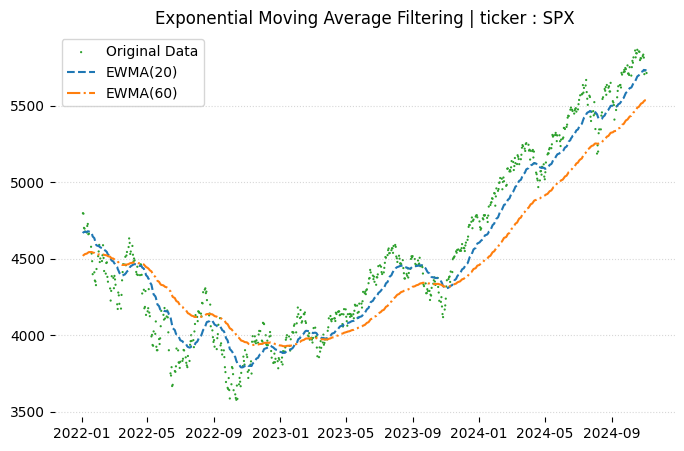

In [88]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    data.loc['2022':, 'Close'].index, 
    data.loc['2022':, 'Close'],
    label = 'Original Data',
    marker = '.',
    edgecolor = 'none',
    s = 10,
    color = 'tab:green'
)
ax.plot(data['Close'].ewm(20).mean().loc['2022':], label = 'EWMA(20)', ls = '--')
ax.plot(data['Close'].ewm(60).mean().loc['2022':], label = 'EWMA(60)', ls = '-.')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Exponential Moving Average Filtering | ticker : SPX')
plt.show()

이동평균 필터는 실제로 단순한 필터 커널을 사용하는 합성곱이다. 더 일반적으로 우리는 일변량 시계열 예측 문제를 다음과 같이 필터를 가진 합성곱으로 표현할 수 있다. 첫째, 이산 합성곱으로 다음과 같은 $x_i$와 $x_j$의 관계를 얻는다.

$$x_{t-i} = \sum_{j=0}^{t-1} \delta_{ij}x_{t-j}, ~~ i \in \{0, \dots, t-1\}$$

여기서 $\delta$는 크로네커 델터이다. kernel filtered time series는 다음과 같은 합성곱이다.

$$\tilde{x}_{t-i} = \sum_{j \in J} K_{j+k+1}x_{t-i-j}, i \in \{k+1, \dots, p-k\}$$

여기서 $J := \{-k, \dots, k\}$이므로 필터의 span은 $|J| = 2k+1$이다. $k$는 작은 정수이고, 커널은 $K$이다. 단순성을 위해 sequence의 끝은 필터링되지 않으나 표기의 편의상 $i \in \{1, \dots, k, p-k+1, \dots, p\}$에 대해 $\tilde{x}_{t-i} = x_{t-i}$로 설정한다. 그러면 $\text{AR}(p)$모형은 다음과 같이 된다.

$$
\begin{align}
\hat{x}_t = & \mu + \sum_{i=1}^p \phi_i \tilde{x}_{t-i} \\
= & \mu + \left( \phi_1 L + \phi_2 L^2 + \cdots + \phi_p L^p\right)\left[ \tilde{x}_t \right] \\ 
= & \mu + \left[ L, L^2, \dots, L^p \right] \phi \left[ \tilde{x}_t \right]
\end{align}
$$

여기서 계수는 $\phi := \left[\phi_i, \dots, \phi_p \right]$이다. 관측 데이터 $\{ \mathcal{X}_s \}_{s=1}^t$의 마지막 $k$값을 필터링하지 않으므로 선견 편향이 없다는 것을 유의하자. 다음과 같이 순전파 출력층과 1개 유닛의 비활성 은닉층으로 구성된 최초의 1D CNN을 표현한다.

$$\hat{x}_t = W_y z_t + b_y, z_t = \left[ \tilde{x}_{t-1}, \dots, \tilde{x}_{t-p} \right]^T, W_y = \phi^T, b_y = \mu$$

여기서 $\tilde{x}_{t-i}$는 $2k+1$개의 가중치로 구성된 하나의 커널을 가진 길이 $p$의 입력 시퀀스의 합성곱으로부터의 $i$번째 출력이다. 이들 가중치는 시간에 대해 고정이며, 따라서 CNN은 저상성 시계열로부터의 예측에만 맞는다. 또한 $\text{RNN}$에 비해 가중치 행렬 $W_y$의 크기가 모델의 time lag 수에 따라서 증가한다는 것을 유의하자.

time lag $p$와 $H$개의 activation hidden kernel을 가진 일변량 CNN 예측 변수는 다음과 같다.

$$
\begin{align}
\hat{x}_t = & W_y \text{vec}(z_t) + b_y \\
[z_t]_{i,m} = & \sigma \left( \sum_{j \in J} K_{m,j+k+1}x_{t-i-j} + [b_h]_m\right) \\
= & \sigma \left( K \circ x_t + b_h\right)
\end{align}
$$

여기서 $m \in \{1, \dots, H\}$는 커널의 인덱스를 표기하고 커널 행렬은 $K \in \mathbb{R}^H$이며 출력 행렬은 $W_y \in \mathbb{R}^{1 \times pH}$이다.

In [137]:
import torch
import torch.nn as nn
import torch.optim as optim

class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, H, p):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels = 1, 
            out_channels = H, 
            kernel_size = 60, 
            padding = 'same'
        ) 
        self.fc = nn.Linear(H * p, 1) 
        
    def forward(self, x):
        #x = torch.relu(self.conv1(x))
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [138]:
def create_lagged_data(series, p):
    X, y = [], []
    for i in range(p, len(series)):
        X.append(series[i-p:i].values)
        y.append(series[i])
    return np.array(X), np.array(y)

In [139]:
p = 60
H = 3
window_size = 10

X, y = create_lagged_data(data['Close'], p)
X = torch.tensor(X).float().unsqueeze(1) 
y = torch.tensor(y).float().unsqueeze(1)

/var/folders/7g/v3wmln7x2mv8wqmn923x0qy40000gn/T/ipykernel_87327/817583328.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(series[i])


In [147]:
cnn_model = ConvolutionalNeuralNetwork(H, p)
optimizer = optim.Adam(cnn_model.parameters(), lr = 0.1)
criterion = nn.MSELoss()

In [148]:
epochs = 1000
batch_size = 32
for epoch in range(epochs):
    cnn_model.train()
    optimizer.zero_grad()
    outputs = cnn_model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

In [149]:
cnn_model.eval()
predictions = cnn_model(X).detach().numpy()

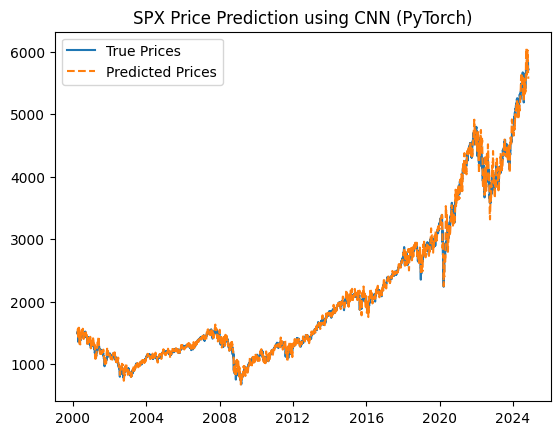

In [150]:
plt.plot(data.index[p:], y.numpy(), label='True Prices')
plt.plot(data.index[p:], predictions, label='Predicted Prices', linestyle='--')
plt.legend()
plt.title('SPX Price Prediction using CNN (PyTorch)')
plt.show()

#### Dimension Reduction

$W_y$의 크기는 lag 수와 커널 수 모두에 따라 증가하므로 추가 계층으로 가중치의 차원을 줄여 과적합을 피하는 것이 바람직할 수 있다. 나중에 이 개념을 다시 살피겠지만 auto-shrinkage 또는 dropout의 대안으로 볼 수 있다.